In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

In [6]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Vidhisha\Downloads\commute_data.csv")



In [7]:
print("\nData Info:")
data.info()



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   start_time                3000 non-null   object 
 1   start_latitude            3000 non-null   float64
 2   start_longitude           3000 non-null   float64
 3   dest_latitude             3000 non-null   float64
 4   dest_longitude            3000 non-null   float64
 5   weather_condition         2850 non-null   object 
 6   day_of_week               3000 non-null   object 
 7   traffic_density           2910 non-null   object 
 8   transport_mode            3000 non-null   object 
 9   historical_delay_minutes  2940 non-null   float64
 10  is_holiday_event          3000 non-null   bool   
 11  road_construction         3000 non-null   bool   
dtypes: bool(2), float64(5), object(5)
memory usage: 240.4+ KB


In [8]:
print("\nData Description:")
print(data.describe())


Data Description:
       start_latitude  start_longitude  dest_latitude  dest_longitude  \
count     3000.000000      3000.000000    3000.000000     3000.000000   
mean        40.699979       -74.001137      40.797478      -73.899484   
std          0.058331         0.057485       0.057117        0.057650   
min         40.600002       -74.099994      40.700048      -73.999989   
25%         40.649161       -74.050854      40.748293      -73.949095   
50%         40.701071       -74.002392      40.796492      -73.900194   
75%         40.750867       -73.952282      40.845736      -73.848969   
max         40.799944       -73.900088      40.899892      -73.800065   

       historical_delay_minutes  
count               2940.000000  
mean                  15.362526  
std                    9.414289  
min                    0.000000  
25%                    8.289398  
50%                   15.153705  
75%                   21.852131  
max                   51.113501  


In [9]:
print("\nMissing Values:")
print(data.isnull().sum())



Missing Values:
start_time                    0
start_latitude                0
start_longitude               0
dest_latitude                 0
dest_longitude                0
weather_condition           150
day_of_week                   0
traffic_density              90
transport_mode                0
historical_delay_minutes     60
is_holiday_event              0
road_construction             0
dtype: int64


In [11]:
# Correcting column name for delay (ensure column names are accurate)
delay_column = [col for col in data.columns if 'delay' in col.lower()][0]

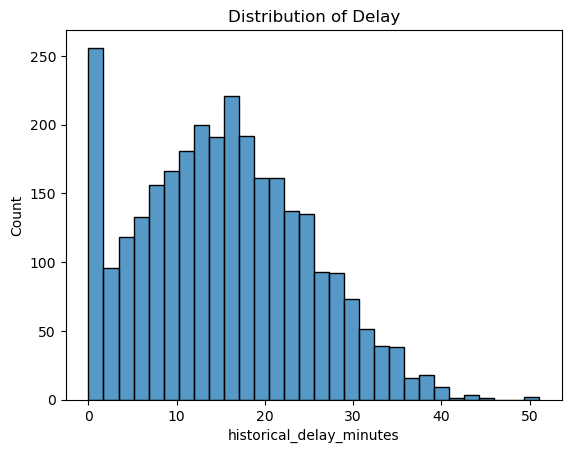

In [12]:
# Visualizing distribution of target variable (delay)
sns.histplot(data[delay_column], bins=30)
plt.title('Distribution of Delay')
plt.show()

In [17]:
# Identifying location columns dynamically
lat_cols = [col for col in data.columns if 'latitude' in col.lower()]
lon_cols = [col for col in data.columns if 'longitude' in col.lower()]

# Calculating distance using Haversine Formula
from math import radians, sin, cos, sqrt, atan2


In [18]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c


In [20]:
# Applying Haversine to dataset
data['distance_km'] = data.apply(lambda row: haversine(row[lat_cols[0]], 
                                                      row[lon_cols[0]], 
                                                      row[lat_cols[1]], 
                                                      row[lon_cols[1]]), axis=1)

In [22]:
# Extracting temporal features (handling errors)
try:
    data['start_time'] = pd.to_datetime(data['Start time of commute'], errors='coerce')
except KeyError:
    print("Start time column not found.")


Start time column not found.


In [29]:
# Creating target variable (delayed > 10 minutes)
data['delayed'] = (data[delay_column] > 10).astype(int)


In [31]:
# Saving processed data
data.to_csv(r"C:\Users\Vidhisha\Downloads\commute_data.csv", index=False)

print("\nEDA and Feature Engineering Completed.")



EDA and Feature Engineering Completed.


In [32]:
#Model training and evaluation

In [34]:
!pip install xgboost --upgrade


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/47/78/27daa8e0287ce205908f089564472af42eb4646146a51d2fbb76ef8f3880/xgboost-3.0.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/150.0 MB 656.4 kB/s eta 0:03:49
   ---------------------------------------- 0.1/150.0 MB 1.2 MB/s eta 0:02:04
   ---------------------------------------- 0.3/150.0 MB 2.0 MB/s eta 0:01:14
   ---------------------------------------- 0.4/150.0 MB 2.1 MB/s eta 0:01:11
   ---------------------------------------- 0.5/150.0 MB 1.8 MB/s eta 0:01:21
   ---------------------------------------- 0.5/150.0 MB 1.8 MB/s eta 0:01:25
   ---------------------------------------- 0.6/150.0 MB 1.8 MB/s eta 0:01:26
   ---------------------------------------- 0.7/150.0 MB 1.8 MB/s eta 0:01:26
   ------------------------

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [2]:
# Load the processed data
data = pd.read_csv(r"C:\Users\Vidhisha\Downloads\commute_data.csv")

In [7]:
# Handling missing values (imputation)
data.fillna(data.median(numeric_only=True), inplace=True)  # For numeric columns
for col in data.select_dtypes(include='object').columns:
    data[col].fillna(data[col].mode()[0], inplace=True)  # For categorical columns

In [8]:
# Handling categorical variables (one-hot encoding)
categorical_cols = data.select_dtypes(include='object').columns
for col in categorical_cols:
    data[col] = data[col].astype('category').cat.codes


In [9]:
# Defining Features and Target
X = data.drop(columns=['delayed', 'start_time'])  # Adjust columns as needed
y = data['delayed']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Model Initialization
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [11]:
# Model Training and Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       206
           1       0.97      0.99      0.98       394

    accuracy                           0.97       600
   macro avg       0.98      0.97      0.97       600
weighted avg       0.98      0.97      0.97       600


Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       206
           1       0.98      1.00      0.99       394

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600


XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       206
           1       1.00      1.00      1.00       394

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00 

C:\Users\Vidhisha\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:53:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [12]:
# Hyperparameter Optimization for Random Forest
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5]
}
gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [15]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
output_dir = 'C:/Users/Vidhisha/Documents/models/'  # Replace with a path you have access to
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

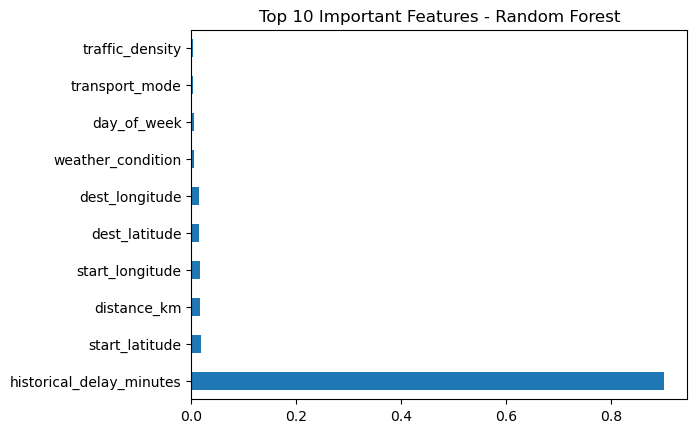

In [21]:
# Best Model
best_rf = gs_rf.best_estimator_
joblib.dump(best_rf, 'C:/Users/Vidhisha/Documents/models/best_random_forest.pkl')

# Feature Importance
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features - Random Forest")
plt.show()


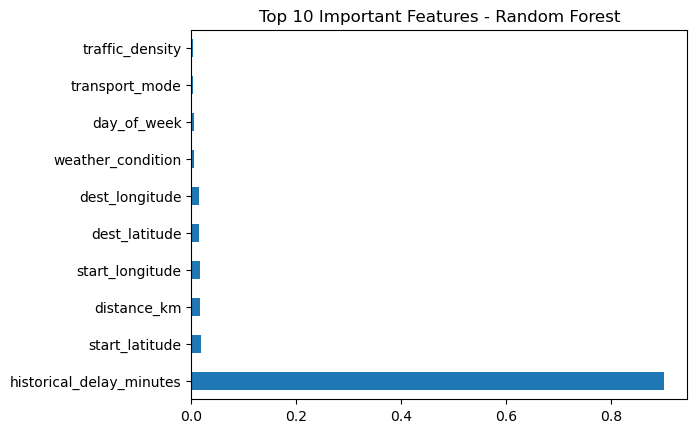

In [20]:


# Feature Importance
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features - Random Forest")
plt.show()
